In [1]:
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np

In [2]:
import cv2
from PIL import Image

def get_bbox(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def get_sample(path, image_id): 
    with open(f'{path}/annotations/maksssksksss{image_id}.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(get_bbox(i))
            labels.append(get_label(i))

        # Annotation is in dictionary format
        sample = {}
        sample["boxes"] = boxes
        sample["labels"] = labels
        sample['image'] = np.array(Image.open(f'images/maksssksksss{image_id}.png').convert('RGB')) 
        
        return sample

In [3]:
def draw_rects(sample, save_path = None):
    result = sample['image'].copy()
    for box, label in zip(sample['boxes'], sample['labels']):
        color = (0, 0, 255)
        if label == 1:
            color = (0, 255, 0)
        elif label == 2:
            color = (255, 0, 0)
        cv2.rectangle(result, (box[0],box[1]), (box[2], box[3]), color, 2)
    
    if save_path:
        im = Image.fromarray(result)
        im.save(save_path)

    plt.imshow(result)

In [4]:
def load_dataset(path = '.'):
    print(f'{path}/annotations/')
    n = len(os.listdir(f'{path}/annotations/'))
    dataset = []
    for i in range(n):
        dataset.append(get_sample(path, i))
    return dataset

In [5]:
dataset = load_dataset('.')

./annotations/


In [6]:
def normalize_dataset(dataset):
    for sample in dataset:
        sample['image'] = sample['image'] / 255.

def standarize_dataset(dataset):
    mean = np.mean([sample['image'].mean() for sample in dataset])
    std_dev = np.std([sample['image'].std() for sample in dataset])
    for sample in dataset:
        sample['image'] = (sample['image'] - mean) / std_dev

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


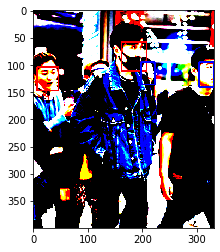

In [7]:
normalize_dataset(dataset)
standarize_dataset(dataset)
draw_rects(dataset[130])

In [8]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import random
import copy

In [9]:
def random_augumentation(sample):
    augumented = copy.deepcopy(sample)
    type = random.randint(0,31)
    
    bbs = []
    for bb in augumented['boxes']:
        bbs.append(BoundingBox(x1=bb[0], x2=bb[2], y1=bb[1], y2=bb[3]))
    bbs = BoundingBoxesOnImage(bbs, shape=augumented['image'].shape)
    
    params = {'fit_output': True}
    if type & 0x1:
        params['rotate'] = (-random.randint(1,15), random.randint(1,15))
    if type & 0x2:
        params['translate_percent'] ={"x": random.uniform(0,0.2), "y": random.uniform(0,0.2)}
    if type & 0x4:
        params['shear'] =(0,random.randint(1,10))
    if type & 0x8:
        flip_hr=iaa.Fliplr(p=1.0)
        augumented['image'], bbs = flip_hr(image = augumented['image'], bounding_boxes=bbs)
    if type & 0x10:
        params['scale'] = random.uniform(1.1,1.3)
    
    aug = iaa.Affine(**params) 
    augumented['image'], bbs = aug(image = augumented['image'], bounding_boxes=bbs)
    for i, bb in enumerate(bbs):
        augumented['boxes'][i] = [bb.x1, bb.y1, bb.x2, bb.y2]
    
    #remove bbs outside the image
    to_delete = list()
    for i, bb in enumerate(augumented['boxes']):
        if (not(0.< bb[0] <= augumented['image'].shape[1])) or \
        (not(0.< bb[2] <= augumented['image'].shape[1])) or \
        (not(0.< bb[1] <= augumented['image'].shape[0])) or \
        (not(0.< bb[3] <= augumented['image'].shape[0])):
            to_delete.append(i)
            
    for index in sorted(to_delete, reverse=True):
        del augumented['boxes'][index]
        del augumented['labels'][index]
        
    return augumented

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


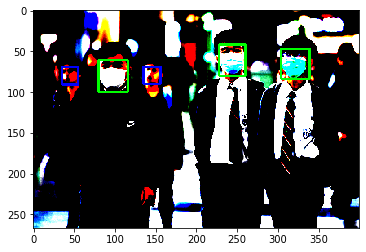

In [13]:
#example augumentation
augumented = random_augumentation(dataset[567])
draw_rects(dataset[567])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


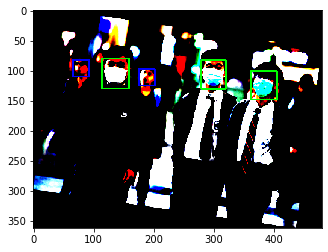

In [12]:
draw_rects(augumented)